# Olympic Athletes
You will be working with a historical dataset on the modern Olympic Games, which includes all the games from Athens 1896 to Rio 2016. The data was scraped from www.sports-reference.com in May 2018.


The dataset athlete_events.csv contains 271’116 rows and 15 columns. Each row corresponds to an individual athlete competing in an individual Olympic event. Can you predict who will win?


The features:
- ID - Unique number for each athlete
- Name - Athlete’s name
- Sex - M or F
- Age - Integer
- Height - In centimeters
- Weight - In kilograms
- Team - Team name
- NOC - National Olympic Committee 3-letter code
- Games - Year and season
- Year - Integer
- Season - Summer or Winter
- City - Host city
- Sport - Sport
- Event - Event
- Medal - Gold, Silver, Bronze, or NA

# Data

## Import dependencies

In [ ]:
!pip install pycaret

     |████████████████████████████████| 266 kB 14.6 MB/s eta 0:00:01
     |████████████████████████████████| 80 kB 11.5 MB/s 
     |████████████████████████████████| 1.7 MB 58.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 14.6 MB 62.3 MB/s 
     |████████████████████████████████| 56 kB 6.9 MB/s 
     |████████████████████████████████| 6.8 MB 62.6 MB/s 
     |████████████████████████████████| 2.0 MB 62.8 MB/s 
     |████████████████████████████████| 1.3 MB 61.6 MB/s 
     |████████████████████████████████| 271 kB 66.5 MB/s 
     |████████████████████████████████| 167 kB 73.2 MB/s 
     |████████████████████████████████| 111 kB 76.4 MB/s 
     |████████████████████████████████| 261 kB 68.1 MB/s 
     |████████████████████████████████| 102 kB 15.8 MB/s 
     |████████████████████████████████| 62 kB 1.2 MB/s 
     |██████

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

## Import data

In [ ]:
# connect to google drive
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
# set working directory google drive
%cd '/gdrive/MyDrive/olympic_data_challange'

/gdrive/MyDrive/olympic_data_challange


In [2]:
# jupyter lab
data = pd.read_csv('../data/athlete_events.csv')
data.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


## Explore data

In [3]:
data.Team.value_counts().reset_index()

,index,Team
0,United States,17847
1,France,11988
2,Great Britain,11404
3,Italy,10260
4,Germany,9326
...,...,...
1179,Briar,1
1180,Hannover,1
1181,Nan-2,1
1182,Brentina,1


In [4]:
data.NOC.value_counts()

USA    18853
FRA    12758
GBR    12256
ITA    10715
GER     9830
       ...  
YMD        5
SSD        3
UNK        2
NBO        2
NFL        1
Name: NOC, Length: 230, dtype: int64

In [5]:
plt.figure()
sns.heatmap(data.corr(), annot=True);

In [6]:
data.describe()

,ID,Age,Height,Weight,Year
count,271116.000000,261642.000000,210945.000000,208241.000000,271116.000000
mean,68248.954396,25.556898,175.338970,70.702393,1978.378480
std,39022.286345,6.393561,10.518462,14.348020,29.877632
min,1.000000,10.000000,127.000000,25.000000,1896.000000
25%,34643.000000,21.000000,168.000000,60.000000,1960.000000
50%,68205.000000,24.000000,175.000000,70.000000,1988.000000
75%,102097.250000,28.000000,183.000000,79.000000,2002.000000
max,135571.000000,97.000000,226.000000,214.000000,2016.000000


following columns can be droped since they do not give more information:
- ID
- Team
- City

## Data cleaning

create new column where Medals are encoded in numbers instead of words

In [7]:
data.Medal.value_counts()

Gold      13372
Bronze    13295
Silver    13116
Name: Medal, dtype: int64

In [8]:
conversion = {'Gold': 1, 'Silver': 2, 'Bronze': 3}

data['Medal_numeric'] = data.apply(lambda row: conversion[row['Medal']] if row['Medal'] in conversion else 0, axis = 1)
data['Medal_numeric'].value_counts()

0    231333
1     13372
3     13295
2     13116
Name: Medal_numeric, dtype: int64

First not needed columns will be droped. This includes Name since there are to many different names to use with one hot encoder on my computer (needs to much RAM). It also includes Medal column since a new column with same information is included

In [9]:
df = data.drop(columns=['ID', 'Name', 'Team', 'City', 'Medal'])
df.head()

,Sex,Age,Height,Weight,NOC,Games,Year,Season,Sport,Event,Medal_numeric
0,M,24.0,180.0,80.0,CHN,1992 Summer,1992,Summer,Basketball,Basketball Men's Basketball,0
1,M,23.0,170.0,60.0,CHN,2012 Summer,2012,Summer,Judo,Judo Men's Extra-Lightweight,0
2,M,24.0,NaN,NaN,DEN,1920 Summer,1920,Summer,Football,Football Men's Football,0
3,M,34.0,NaN,NaN,DEN,1900 Summer,1900,Summer,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,1
4,F,21.0,185.0,82.0,NED,1988 Winter,1988,Winter,Speed Skating,Speed Skating Women's 500 metres,0


## Visualize Data

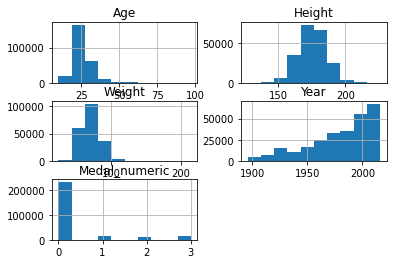

In [ ]:
df.hist();

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


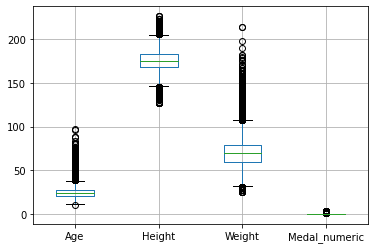

In [ ]:
df.drop(columns=['Year']).boxplot();

In [ ]:
df[(df.Age > 70) & (df.Medal_numeric != 0)]

,Sex,Age,Height,Weight,NOC,Games,Year,Season,Sport,Event,Medal_numeric
44584,M,73.0,NaN,NaN,GBR,1948 Summer,1948,Summer,Art Competitions,"Art Competitions Mixed Painting, Graphic Arts",2
60009,M,72.0,NaN,NaN,BEL,1936 Summer,1936,Summer,Art Competitions,"Art Competitions Mixed Sculpturing, Medals",3
150755,M,71.0,NaN,NaN,FRA,1900 Summer,1900,Summer,Sailing,Sailing Mixed 0.5-1 Ton,2
150756,M,71.0,NaN,NaN,FRA,1900 Summer,1900,Summer,Sailing,Sailing Mixed 0.5-1 Ton,3
233395,M,72.0,NaN,NaN,SWE,1920 Summer,1920,Summer,Shooting,"Shooting Men's Running Target, Double Shot, Team",2


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Sex            271116 non-null  object 
 1   Age            261642 non-null  float64
 2   Height         210945 non-null  float64
 3   Weight         208241 non-null  float64
 4   NOC            271116 non-null  object 
 5   Games          271116 non-null  object 
 6   Year           271116 non-null  int64  
 7   Season         271116 non-null  object 
 8   Sport          271116 non-null  object 
 9   Event          271116 non-null  object 
 10  Medal_numeric  271116 non-null  int64  
dtypes: float64(3), int64(2), object(6)
memory usage: 22.8+ MB


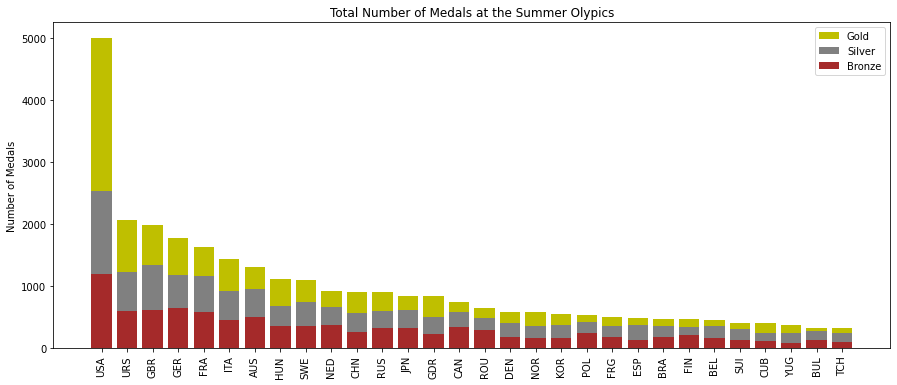

In [ ]:
df_summer_gold = data[(data['Season'] == 'Summer') & (data['Medal'] == 'Gold')]
df_summer_gold_count = df_summer_gold.groupby('NOC')['Medal'].count().to_frame().reset_index()
df_summer_gold_count = df_summer_gold_count.rename(columns={"Medal": 'Gold'})


df_summer_silver = data[(data['Season'] == 'Summer') & (data['Medal'] == 'Silver')]
df_summer_silver_count = df_summer_silver.groupby('NOC')['Medal'].count().to_frame().reset_index()
df_summer_silver_count = df_summer_silver_count.rename(columns={"Medal": 'Silver'})

df_summer_bronze = data[(data['Season'] == 'Summer') & (data['Medal'] == 'Bronze')]
df_summer_bronze_count = df_summer_bronze.groupby('NOC')['Medal'].count().to_frame().reset_index()
df_summer_bronze_count = df_summer_bronze_count.rename(columns={"Medal": 'Bronze'})

df_summer_medals  = pd.merge(df_summer_gold_count,df_summer_silver_count, left_on='NOC', right_on='NOC')
df_summer_medals = pd.merge(df_summer_medals, df_summer_bronze_count, left_on='NOC', right_on='NOC')

df_summer_medals['Total'] = df_summer_medals['Gold'] + df_summer_medals['Silver'] + df_summer_medals['Bronze']
df_summer_medals = df_summer_medals.sort_values('Total',ascending=False).reset_index()

fig = plt.figure(figsize=(15,6))
ax = plt.gca()
# create data
x = df_summer_medals['NOC'][:30]
y1 = df_summer_medals['Gold'][:30]
y2 = df_summer_medals['Silver'][:30]
y3 = df_summer_medals['Bronze'][:30]

# plot bars in stack manner
plt.bar(x, y1, bottom=y3+y2, color='y', label = 'Gold')
plt.bar(x, y2, bottom=y3, color='gray', label = 'Silver')
plt.bar(x, y3, color='brown', label = 'Bronze')
ax.legend()
plt.xticks(rotation=90)
plt.ylabel('Number of Medals')
plt.title('Total Number of Medals at the Summer Olypics')
plt.savefig('medals_summer.png')
plt.show()

## Impute missing data

inpute missing data in float columns (Age, Height, Weight)

In [ ]:
from sklearn.impute import KNNImputer

df_numeric = df.select_dtypes(include='float64')

num_cols = df_numeric.columns
knn_imp = KNNImputer(n_neighbors=5)
df_numeric = pd.DataFrame(knn_imp.fit_transform(df_numeric),
                          columns=num_cols)
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Age     271116 non-null  float64
 1   Height  271116 non-null  float64
 2   Weight  271116 non-null  float64
dtypes: float64(3)
memory usage: 6.2 MB


In [10]:
# save data including data points in csv file
#df_numeric.to_csv('inputed_numeric_data.csv')
#load inputed data
df_numeric = pd.read_csv('../data/inputed_numeric_data.csv', index_col=0)

In [11]:
df_numeric.head()

,Age,Height,Weight
0,24.0,180.0,80.0
1,23.0,170.0,60.0
2,24.0,190.4,67.8
3,34.0,176.6,85.4
4,21.0,185.0,82.0


In [12]:
# Combine inputed data with rest of dataframe. Age, height, and weight must be droped from original dataframe before.
df_inputed = pd.concat([df.drop(columns=['Age', 'Height', 'Weight']), df_numeric], axis = 1)
df_inputed.head()

,Sex,NOC,Games,Year,Season,Sport,Event,Medal_numeric,Age,Height,Weight
0,M,CHN,1992 Summer,1992,Summer,Basketball,Basketball Men's Basketball,0,24.0,180.0,80.0
1,M,CHN,2012 Summer,2012,Summer,Judo,Judo Men's Extra-Lightweight,0,23.0,170.0,60.0
2,M,DEN,1920 Summer,1920,Summer,Football,Football Men's Football,0,24.0,190.4,67.8
3,M,DEN,1900 Summer,1900,Summer,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,1,34.0,176.6,85.4
4,F,NED,1988 Winter,1988,Winter,Speed Skating,Speed Skating Women's 500 metres,0,21.0,185.0,82.0


# Model

## preprocess data and split test/train set depending on year.

We decided to use the data from year 2016 as test data

In [13]:
X_year = df_inputed.drop(columns=['Medal_numeric'])

X_cat = X_year.select_dtypes(include='object')
X_num = X_year.select_dtypes(exclude='object')
cat_cols = X_cat.columns
num_cols = X_num.columns

from sklearn.preprocessing import OneHotEncoder

cat_dummy_encoder = OneHotEncoder(handle_unknown='ignore') # ignore categories that may be only in the test data
X_cat_ohe = cat_dummy_encoder.fit_transform(X_cat).toarray()
cat_ohe_cols = cat_dummy_encoder.get_feature_names(cat_cols)
X_cat_ohe = pd.DataFrame(X_cat_ohe, 
                               columns=cat_ohe_cols)
X_cat_ohe.head()


from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_num_scaled = ss.fit_transform(X_num)
X_num_scaled = pd.DataFrame(X_num_scaled, 
                                  columns=num_cols)
X_num_scaled.head()


X_year = pd.concat([X_num_scaled, X_cat_ohe], axis=1)
final_columns = X_year.columns.tolist()
# just to maintain a proper column order
X_year = X_year[final_columns]
X_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Columns: 1120 entries, Year to Event_Wrestling Women's Middleweight, Freestyle
dtypes: float64(1120)
memory usage: 2.3 GB


In [14]:
X_year_train = X_year[df_inputed.Year != 2016]
X_year_test = X_year[df_inputed.Year == 2016]
X_year_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 257428 entries, 0 to 271115
Columns: 1120 entries, Year to Event_Wrestling Women's Middleweight, Freestyle
dtypes: float64(1120)
memory usage: 2.2 GB


In [15]:
y_year_train = df_inputed[df_inputed.Year != 2016]['Medal_numeric']
y_year_test = df_inputed[df_inputed.Year == 2016]['Medal_numeric']
y_year_test

80        0
139       0
140       0
141       0
142       0
         ..
271024    0
271053    0
271054    0
271055    0
271110    0
Name: Medal_numeric, Length: 13688, dtype: int64

## Overview

Get an overview of different models to figure out which work best

In [ ]:
df_inputed

,Sex,NOC,Games,Year,Season,Sport,Event,Medal_numeric,Age,Height,Weight
0,M,CHN,1992 Summer,1992,Summer,Basketball,Basketball Men's Basketball,0,24.0,180.0,80.0
1,M,CHN,2012 Summer,2012,Summer,Judo,Judo Men's Extra-Lightweight,0,23.0,170.0,60.0
2,M,DEN,1920 Summer,1920,Summer,Football,Football Men's Football,0,24.0,190.4,67.8
3,M,DEN,1900 Summer,1900,Summer,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,1,34.0,176.6,85.4
4,F,NED,1988 Winter,1988,Winter,Speed Skating,Speed Skating Women's 500 metres,0,21.0,185.0,82.0
...,...,...,...,...,...,...,...,...,...,...,...
271111,M,POL,1976 Winter,1976,Winter,Luge,Luge Mixed (Men)'s Doubles,0,29.0,179.0,89.0
271112,M,POL,2014 Winter,2014,Winter,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",0,27.0,176.0,59.0
271113,M,POL,2014 Winter,2014,Winter,Ski Jumping,"Ski Jumping Men's Large Hill, Team",0,27.0,176.0,59.0
271114,M,POL,1998 Winter,1998,Winter,Bobsleigh,Bobsleigh Men's Four,0,30.0,185.0,96.0


In [16]:
from pycaret.classification import *

reg = setup(data=df_inputed, 
            target = 'Medal_numeric', 
            session_id=13, 
            log_experiment=True, 
            experiment_name='model_overview')

,Description,Value
0,session_id,13
1,Target,Medal_numeric
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(271116, 11)"
5,Missing Values,False
6,Numeric Features,4
7,Categorical Features,6
8,Ordinal Features,False
9,High Cardinality Features,False


In [17]:
best_model = compare_models(fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9182,0.9027,0.6448,0.9115,0.9104,0.6378,0.6529,211.4080
rf,Random Forest Classifier,0.9042,0.8957,0.5262,0.9023,0.8856,0.5118,0.5681,136.7180
dt,Decision Tree Classifier,0.8872,0.8001,0.6516,0.8864,0.8868,0.5712,0.5712,20.7680
xgboost,Extreme Gradient Boosting,0.8701,0.8439,0.3387,0.8676,0.8232,0.2048,0.3220,1028.0660
catboost,CatBoost Classifier,0.8681,0.8354,0.3285,0.8577,0.8190,0.1889,0.3022,65.3640
lightgbm,Light Gradient Boosting Machine,0.8671,0.8450,0.3222,0.8600,0.8169,0.1738,0.2913,9.7660
gbc,Gradient Boosting Classifier,0.8589,0.7704,0.2788,0.8594,0.7991,0.0728,0.1845,1007.0640
ridge,Ridge Classifier,0.8543,0.0000,0.2579,0.7767,0.7902,0.0302,0.0944,5.2300
qda,Quadratic Discriminant Analysis,0.8541,0.5082,0.2547,0.7792,0.7887,0.0206,0.0797,80.5260
ada,Ada Boost Classifier,0.8537,0.7315,0.2522,0.7705,0.7869,0.0069,0.0485,58.1620


We decided to use the Decision Tree Classifier for further steps.

## Decision Tree Classifier

In [18]:
from sklearn.tree import DecisionTreeClassifier

dtc_year = DecisionTreeClassifier()
dtc_year.fit(X_year_train, y_year_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
import joblib

# save the model to disk
filename = 'dtc_default_model.sav'
joblib.dump(dtc_year, filename)

['dtc_default_model.sav']

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(dtc_year, X_year_train, y_year_train, cv=5, scoring='f1_weighted')
scores

array([0.8978776 , 0.89127566, 0.88729468, 0.894718  , 0.88952583])

### Tuning Hyperparameters

#### Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

clf = DecisionTreeClassifier(random_state=42)

# Hyperparameter Optimization
parameters = {'max_features': ['log2', 'sqrt', None, 0.8],
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10, 50, None],
              'min_samples_split': [2, 3, 50, 100],
              'min_samples_leaf': [1, 5, 8, 10]
             }
# Run the grid search
grid_obj = GridSearchCV(clf, parameters, cv=5)
grid_obj = grid_obj.fit(X_year_train, y_year_train)
# Set the clf to the best combination of parameters
print(grid_obj.best_estimator_)
clf = grid_obj.best_estimator_
# Train the model using the training sets
clf.fit(X_year_test, y_year_train)

# Prediction on test set
y_pred_dt = clf.predict(X_year_test)

# Calculating the accuracy
acc_dt_grid = round( metrics.accuracy_score(y_year_test, y_pred_dt) * 100, 2 )
print( 'Accuracy of Decision Tree model : ', acc_dt_grid )

#### Random Search

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

random_search = {'max_features': ['log2', 'sqrt', None, 0.8],
                 'criterion': ['entropy', 'gini'],
                 'max_depth': [10, 20, None],
                 'min_samples_split': [2, 3, 50, 100],
                 'min_samples_leaf': [1, 5, 8, 10]}

clf = DecisionTreeClassifier(random_state=42)


random_search_obj = RandomizedSearchCV(estimator=clf, 
                           param_distributions=random_search, 
                           n_iter=20, # total number of models it will try out by random selection
                           scoring='f1_weighted',
                           cv=3, verbose=1, random_state=42, n_jobs=-1) # n_jobs=-1 tells to use all the CPU's

random_search_obj.fit(X_year_train, y_year_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 16.1min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=42,
            

In [20]:
print(random_search_obj.best_estimator_)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=0.8, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')


Run best Model

In [21]:
from sklearn.tree import DecisionTreeClassifier
# Set the clf to the best combination of parameters
clf = DecisionTreeClassifier(max_features=0.8, min_samples_leaf=5, random_state=42)
# Train the model using the training sets
clf.fit(X_year_train, y_year_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=0.8, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [ ]:
import joblib

# save the model to disk
filename = 'random_tuned_model.sav'
joblib.dump(clf, filename)

In [ ]:
# load model
'''
import joblib
filename = 'random_tuned_model.sav'
clf = joblib.load(filename)
result = clf.score(X_year_test, y_year_test)
print(result)
'''

In [22]:
from sklearn.model_selection import cross_val_score
# cross val scores
scores = cross_val_score(clf, X_year_train, y_year_train, cv=5, scoring='f1_weighted')
scores

array([0.88393997, 0.88278091, 0.88061711, 0.88563559, 0.88210904])

## Prediction

In [23]:
# Prediction on test set
y_pred_dt = clf.predict(X_year_test)

# Calculating the accuracy and F1
from sklearn import metrics
acc_dt_ran = round( metrics.accuracy_score(y_year_test, y_pred_dt) * 100, 2 )
f1_dt = round(metrics.f1_score(y_year_test, y_pred_dt, average='weighted') * 100, 2)
print('Accuracy of Decision Tree model : ', acc_dt_ran)
print('F1 of Decision Tree model : ', f1_dt)

Accuracy of Decision Tree model :  82.89
F1 of Decision Tree model :  80.39


# Explore Model 

## Confusion Matrix

In [24]:
from sklearn.metrics import classification_report

#print(classification_report(y_true, y_pred, target_names=target_names))
target_names = ['None', 'Gold', 'Silver', 'Bronze']
print(classification_report(y_year_test, y_pred_dt, target_names=target_names))

              precision    recall  f1-score   support

        None       0.89      0.95      0.92     11665
        Gold       0.39      0.32      0.35       665
      Silver       0.11      0.05      0.07       655
      Bronze       0.04      0.02      0.02       703

    accuracy                           0.83     13688
   macro avg       0.36      0.33      0.34     13688
weighted avg       0.78      0.83      0.80     13688



In [25]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_year_test, y_pred_dt)
cm

array([[11090,   167,   182,   226],
       [  350,   210,    44,    61],
       [  491,    76,    33,    55],
       [  566,    82,    42,    13]], dtype=int64)

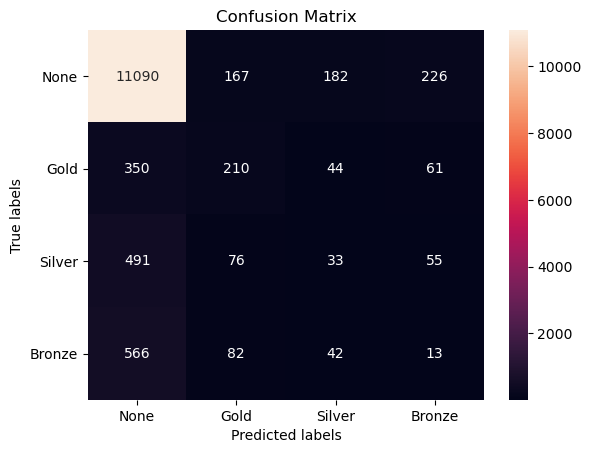

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt     

fig, ax= plt.subplots()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['None', 'Gold', 'Silver', 'Bronze']); ax.yaxis.set_ticklabels(['None', 'Gold', 'Silver', 'Bronze'])
plt.yticks(rotation=0)
plt.savefig('confusion_matrix.png')
plt.show();

## Number of Medals Predicted vs. Actual Data

In [34]:
df_test = df_inputed[df_inputed.Year == 2016]
df_test['predicted_medal'] = y_pred_dt
df_test.head()

,Sex,NOC,Games,Year,Season,Sport,Event,Medal_numeric,Age,Height,Weight,predicted_medal
80,F,ROU,2016 Summer,2016,Summer,Weightlifting,Weightlifting Women's Super-Heavyweight,0,22.0,170.0,125.0,0
139,M,ESP,2016 Summer,2016,Summer,Gymnastics,Gymnastics Men's Individual All-Around,0,23.0,167.0,64.0,0
140,M,ESP,2016 Summer,2016,Summer,Gymnastics,Gymnastics Men's Floor Exercise,0,23.0,167.0,64.0,0
141,M,ESP,2016 Summer,2016,Summer,Gymnastics,Gymnastics Men's Parallel Bars,0,23.0,167.0,64.0,0
142,M,ESP,2016 Summer,2016,Summer,Gymnastics,Gymnastics Men's Horizontal Bar,0,23.0,167.0,64.0,0


In [35]:
medals = list(df_test.groupby(df_test.Medal_numeric).count().predicted_medal)
predicted_medals = list(df_test.groupby(df_test.predicted_medal).count().Medal_numeric)

df_medals = pd.DataFrame({'Medal_name': ['None', 'Gold', 'Silver', 'Bronze'],
                          'Medal_numeric': [0, 1, 2, 3],
                          'Data': medals,
                          'Predicted': predicted_medals})
df_medals

,Medal_name,Medal_numeric,Data,Predicted
0,None,0,11665,12497
1,Gold,1,665,535
2,Silver,2,655,301
3,Bronze,3,703,355


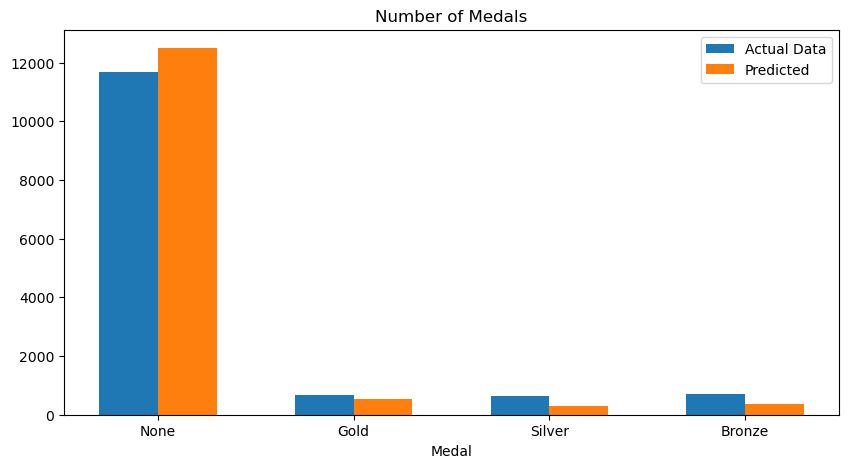

In [36]:
# Figure size
plt.figure(figsize=(10,5))

# Width of a bar 
width = 0.3       

# Plotting
plt.bar(df_medals.Medal_numeric, df_medals.Data , width, label='Actual Data')
plt.bar(df_medals.Medal_numeric + width, df_medals.Predicted, width, label='Predicted')

plt.xlabel('Medal')
# plt.ylabel('Here goes y-axis label')
plt.title('Number of Medals')

# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
plt.xticks(df_medals.Medal_numeric + width / 2, (df_medals.Medal_name))

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.savefig('number_of_medals.png')
plt.show();

## Number of Medals per Country

In [43]:
df = pd.read_csv('../data/athlete_events.csv')
df_numeric = pd.read_csv('../data/inputed_numeric_data.csv', index_col=0)

df = pd.concat([df.drop(columns=['Age', 'Height', 'Weight']), df_numeric], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      271116 non-null  int64  
 1   Name    271116 non-null  object 
 2   Sex     271116 non-null  object 
 3   Team    271116 non-null  object 
 4   NOC     271116 non-null  object 
 5   Games   271116 non-null  object 
 6   Year    271116 non-null  int64  
 7   Season  271116 non-null  object 
 8   City    271116 non-null  object 
 9   Sport   271116 non-null  object 
 10  Event   271116 non-null  object 
 11  Medal   39783 non-null   object 
 12  Age     271116 non-null  float64
 13  Height  271116 non-null  float64
 14  Weight  271116 non-null  float64
dtypes: float64(3), int64(2), object(10)
memory usage: 31.0+ MB


In [44]:
df_16 = df[df.Year == 2016]
df_16.head()

,ID,Name,Sex,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Age,Height,Weight
80,22,Andreea Aanei,F,Romania,ROU,2016 Summer,2016,Summer,Rio de Janeiro,Weightlifting,Weightlifting Women's Super-Heavyweight,NaN,22.0,170.0,125.0
139,51,Nstor Abad Sanjun,M,Spain,ESP,2016 Summer,2016,Summer,Rio de Janeiro,Gymnastics,Gymnastics Men's Individual All-Around,NaN,23.0,167.0,64.0
140,51,Nstor Abad Sanjun,M,Spain,ESP,2016 Summer,2016,Summer,Rio de Janeiro,Gymnastics,Gymnastics Men's Floor Exercise,NaN,23.0,167.0,64.0
141,51,Nstor Abad Sanjun,M,Spain,ESP,2016 Summer,2016,Summer,Rio de Janeiro,Gymnastics,Gymnastics Men's Parallel Bars,NaN,23.0,167.0,64.0
142,51,Nstor Abad Sanjun,M,Spain,ESP,2016 Summer,2016,Summer,Rio de Janeiro,Gymnastics,Gymnastics Men's Horizontal Bar,NaN,23.0,167.0,64.0


### Actual Data 2016

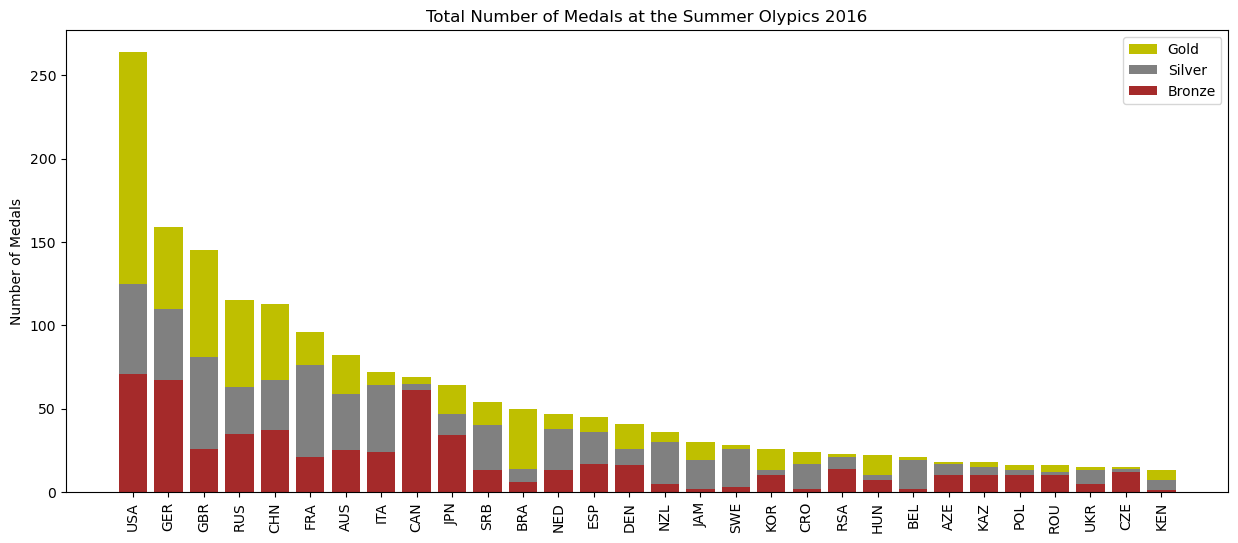

In [46]:
df_summer_gold = df_16[(df_16['Season'] == 'Summer') & (df_16['Medal'] == 'Gold')]
df_summer_gold_count = df_summer_gold.groupby('NOC')['Medal'].count().to_frame().reset_index()
df_summer_gold_count = df_summer_gold_count.rename(columns={"Medal": 'Gold'})


df_summer_silver = df_16[(df_16['Season'] == 'Summer') & (df_16['Medal'] == 'Silver')]
df_summer_silver_count = df_summer_silver.groupby('NOC')['Medal'].count().to_frame().reset_index()
df_summer_silver_count = df_summer_silver_count.rename(columns={"Medal": 'Silver'})

df_summer_bronze = df_16[(df_16['Season'] == 'Summer') & (df_16['Medal'] == 'Bronze')]
df_summer_bronze_count = df_summer_bronze.groupby('NOC')['Medal'].count().to_frame().reset_index()
df_summer_bronze_count = df_summer_bronze_count.rename(columns={"Medal": 'Bronze'})

df_summer_medals  = pd.merge(df_summer_gold_count,df_summer_silver_count, left_on='NOC', right_on='NOC')
df_summer_medals = pd.merge(df_summer_medals, df_summer_bronze_count, left_on='NOC', right_on='NOC')

df_summer_medals['Total'] = df_summer_medals['Gold'] + df_summer_medals['Silver'] + df_summer_medals['Bronze']
df_summer_medals = df_summer_medals.sort_values('Total',ascending=False).reset_index()

fig = plt.figure(figsize=(15,6))
ax = plt.gca()
# create data
x = df_summer_medals['NOC'][:30]
y1 = df_summer_medals['Gold'][:30]
y2 = df_summer_medals['Silver'][:30]
y3 = df_summer_medals['Bronze'][:30]

# plot bars in stack manner
plt.bar(x, y1, bottom=y3+y2, color='y', label = 'Gold')
plt.bar(x, y2, bottom=y3, color='gray', label = 'Silver')
plt.bar(x, y3, color='brown', label = 'Bronze')
ax.legend()
plt.xticks(rotation=90)
plt.ylabel('Number of Medals')
plt.title('Total Number of Medals at the Summer Olypics 2016')
plt.savefig('medals_summer_2016.png')
plt.show()

### Predicted Data 2016

In [47]:
# convert medal data back to words
conversion = {1: 'Gold', 2: 'Silver', 3: 'Bronze'}

df_test['Medal'] = df_test.apply(lambda row: conversion[row['predicted_medal']] if row['predicted_medal'] in conversion else 'None', axis = 1)
df_test.head()

,Sex,NOC,Games,Year,Season,Sport,Event,Medal_numeric,Age,Height,Weight,predicted_medal,Medal
80,F,ROU,2016 Summer,2016,Summer,Weightlifting,Weightlifting Women's Super-Heavyweight,0,22.0,170.0,125.0,0,None
139,M,ESP,2016 Summer,2016,Summer,Gymnastics,Gymnastics Men's Individual All-Around,0,23.0,167.0,64.0,0,None
140,M,ESP,2016 Summer,2016,Summer,Gymnastics,Gymnastics Men's Floor Exercise,0,23.0,167.0,64.0,0,None
141,M,ESP,2016 Summer,2016,Summer,Gymnastics,Gymnastics Men's Parallel Bars,0,23.0,167.0,64.0,0,None
142,M,ESP,2016 Summer,2016,Summer,Gymnastics,Gymnastics Men's Horizontal Bar,0,23.0,167.0,64.0,0,None


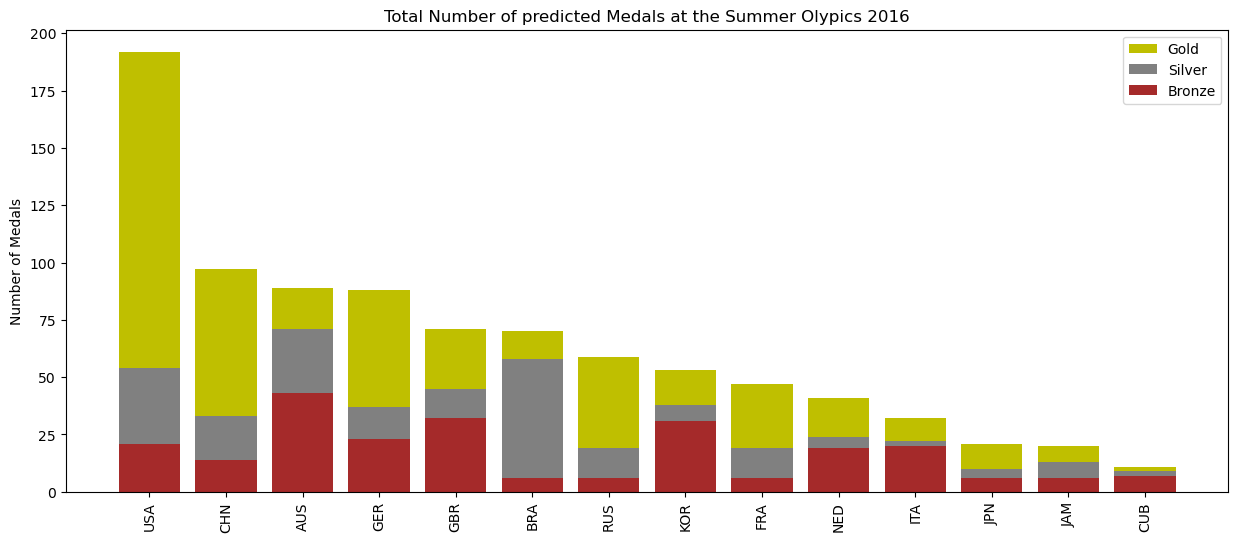

In [48]:
df_summer_gold = df_test[df_test['Medal'] == 'Gold']
df_summer_gold_count = df_summer_gold.groupby('NOC')['Medal'].count().to_frame().reset_index()
df_summer_gold_count = df_summer_gold_count.rename(columns={"Medal": 'Gold'})


df_summer_silver = df_test[df_test['Medal'] == 'Silver']
df_summer_silver_count = df_summer_silver.groupby('NOC')['Medal'].count().to_frame().reset_index()
df_summer_silver_count = df_summer_silver_count.rename(columns={"Medal": 'Silver'})

df_summer_bronze = df_test[df_test['Medal'] == 'Bronze']
df_summer_bronze_count = df_summer_bronze.groupby('NOC')['Medal'].count().to_frame().reset_index()
df_summer_bronze_count = df_summer_bronze_count.rename(columns={"Medal": 'Bronze'})

df_summer_medals  = pd.merge(df_summer_gold_count,df_summer_silver_count, left_on='NOC', right_on='NOC')
df_summer_medals = pd.merge(df_summer_medals, df_summer_bronze_count, left_on='NOC', right_on='NOC')

df_summer_medals['Total'] = df_summer_medals['Gold'] + df_summer_medals['Silver'] + df_summer_medals['Bronze']
df_summer_medals = df_summer_medals.sort_values('Total',ascending=False).reset_index()

fig = plt.figure(figsize=(15,6))
ax = plt.gca()
# create data
x = df_summer_medals['NOC']
y1 = df_summer_medals['Gold']
y2 = df_summer_medals['Silver']
y3 = df_summer_medals['Bronze']

# plot bars in stack manner
plt.bar(x, y1, bottom=y3+y2, color='y', label = 'Gold')
plt.bar(x, y2, bottom=y3, color='gray', label = 'Silver')
plt.bar(x, y3, color='brown', label = 'Bronze')
ax.legend()
plt.xticks(rotation=90)
plt.ylabel('Number of Medals')
plt.title('Total Number of predicted Medals at the Summer Olypics 2016')
plt.savefig('medals_summer_predicted_2016.png')
plt.show()